# Need to run automatic lfilter as pbs job

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
# import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client
import xrft


def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38849 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:35573' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38849/status,
Dashboard: /proxy/38849/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35573,Workers: 7
Dashboard: /proxy/38849/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:46271,Total threads: 4
Dashboard: /proxy/39787/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:45283,


## Plot more polished spectra of Kinetic Energy

**Inputs:** t0, time window, region. Rectangle either in generation, propagation, shoaling or eddy-box (subset of shoaling)

1. Calculate KE in region of interest
2. Average spatially
3. Plot power spectrum. 
4. Plot with $\omega$ multipled through on y axis


In [11]:
def plot_power_spectrum(data,ax,color,label = None,linestyle = "solid"):

    m2 = 1 / (12.45 * 3600)
    f = 1 / (17.89 * 3600)

    ps = xrft.power_spectrum(data, dim=['time'], window=True,true_phase = True)
    if "xb" in data.dims:
        ps = ps.mean("xb")
    if "yb" in data.dims:
        ps = ps.mean("yb")
    if "zl" in data.dims:
        ps = ps.mean("zl")
    if label != None:
        (ps.freq_time * ps).plot(xscale = "log",yscale = "log",ax = ax,color = color,label = label,linestyle = linestyle)
    else:
        (ps.freq_time * ps).plot(xscale = "log",yscale = "log",ax = ax,color = color,linestyle = linestyle)
    # ps.plot(ax = ax)

    return 

def get_data(s,timeslice =200,zrange = (10,30)):
    """
    Given a dictionary s of experiment names, such that 
    s[i] = {"expt":"full-20","time":t0}
    return a dictionary of data for each of these combinations
    This can later be split up into the regions of interest
    """
    data = {}
    for i in s:
        vels = tt.collect_data(
            s[i]["expt"],
            rawdata = ["u","v"],timerange = (s[i]["time"] - timeslice,s[i]["time"] + timeslice)).sel(yb = slice(-50,50))
        KE = 0.5*(vels.u**2 + vels.v**2)
        KE = KE.assign_coords({"time":KE.time * 3600}).chunk({"time":-1})

        data[i] = KE



    return data

def ps_tidyup(ax,title):
    """
    Add M2 and f lines to a power spectrum plot
    """

    m2 = 1 / (12.45 * 3600)
    f = 1 / (17.89 * 3600)

    maxi = 1e-2

    ax.vlines(m2,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.vlines(2 * m2,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.vlines(f,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.vlines(2 * f,0,maxi,color = "grey",linestyle = "dotted",alpha = 0.3)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel(r"$\omega$KE per frequency")
    # Instead of using labels, put the text of M2 f ect on the plot near the x axis
    ax.text(1.01 * m2,1.1 * 1e-10,"M2")
    ax.text(1.01 * f,1.1 * 1e-10,"f")
    ax.text(1.01 * 2 * f,1.1 * 1e-10,"2f")
    ax.text(1.01 * 2 * m2,1.1 * 1e-10,"2M2")

    ax.set_title(title)
    return 

def SelectRegion(data,region):
    data = data.sel(xb = slice(regions[region][0],regions[region][1])).chunk({"time":-1})
    return data

regions = {"gen": [1300,None],"prop": [700,800],"eddy": [200,250]}


## Get the data to compare for 20th and 40th degree. 
Here we just take a single time for both. Later, compare eddy and no eddy

In [3]:

## Intentionally choose times with no eddies for now
ToCompare20 = {
    "No Tide 20":{
        "expt":"notide-20",
        "time":44900
    },
    "Blank 20":{
        "expt":"blank-20",
        "time":60 * 24
    },
    "Tide 20":{
        "expt":"full-20",
        "time":38000
    }
}

ToCompare40 = {
    "No Tide 40":{
        "expt":"notide-40",
        "time":20000
    },
    "Blank 40":{
        "expt":"blank-40",
        "time":60 * 24
    },
    "Tide 40":{
        "expt":"full-40",
        "time":20000
    }
}

data_20 = get_data(ToCompare20)
data_40 = get_data(ToCompare40)

loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.
loading u...	done.
loading v...	done.


In [4]:
data_20["Blank 20"]

<xarray.DataArray (time: 401, zl: 100, yb: 25, xb: 376)> Size: 2GB
dask.array<rechunk-merge, shape=(401, 100, 25, 376), dtype=float32, chunksize=(401, 100, 6, 376), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 800B 2.704 8.126 13.58 ... 5.339e+03 5.443e+03
  * xb       (xb) float64 3kB -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 200B -48.0 -44.0 -40.0 -36.0 ... 36.0 40.0 44.0 48.0
    lon      (yb, xb) float64 75kB dask.array<chunksize=(25, 376), meta=np.ndarray>
    lat      (yb, xb) float64 75kB dask.array<chunksize=(25, 376), meta=np.ndarray>
  * time     (time) float64 3kB 4.464e+06 4.468e+06 ... 5.9e+06 5.904e+06

## Compare 20th degree experiments away from eddy

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecat

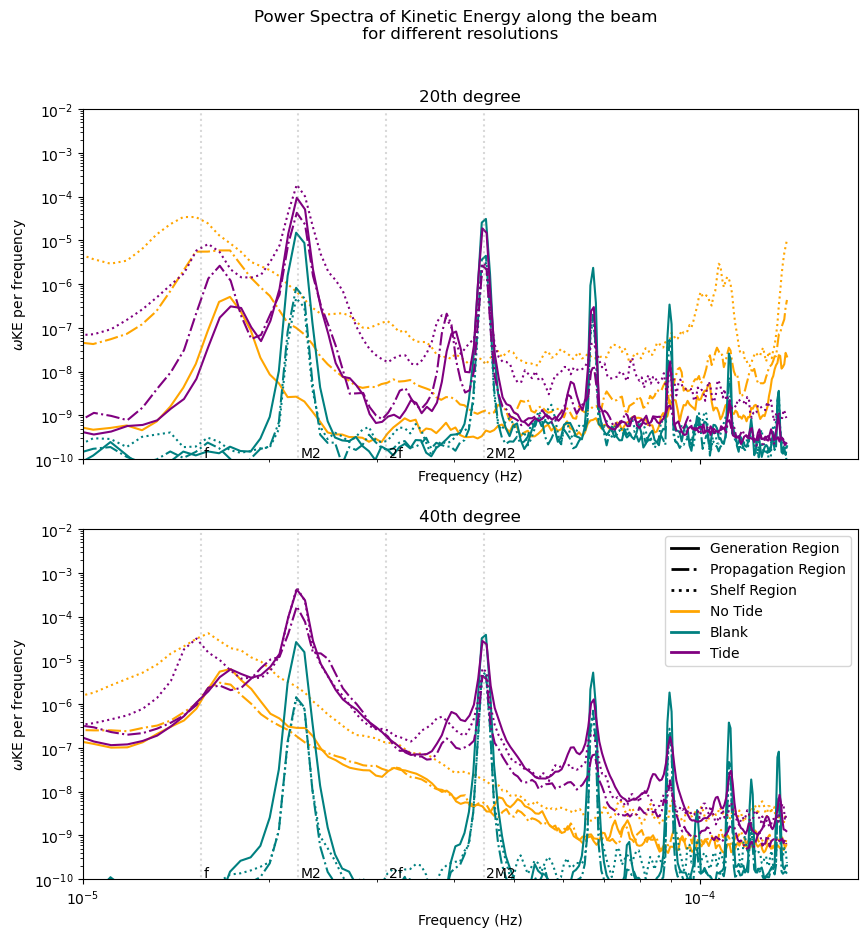

In [14]:
fig,ax = plt.subplots(2,1,figsize = (10,10),sharex=True)
from matplotlib.lines import Line2D

cmap = plt.get_cmap('Dark2')
colours = ["orange","teal","purple"]

legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='Generation Region'),
    Line2D([0], [0], color="black", linestyle="dashdot",lw=2, label='Propagation Region'),
    Line2D([0], [0], color="black", linestyle="dotted",lw=2, label='Shelf Region'),
]

for i,data in enumerate([data_20,data_40]):
    for j,d in enumerate(data):
        # Loop over each data selection
        KE = data[d]
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(20,None)),"gen"),ax[i],colours[j])
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(20,None)),"prop"),ax[i],colours[j],linestyle = "dashdot")
        plot_power_spectrum(SelectRegion(KE.isel(zl = slice(20,None)),"eddy"),ax[i],colours[j],linestyle = "dotted")
        if i == 0:
            legend_elements.append(Line2D([0], [0], color=colours[j], lw=2, label=d.split(" 20")[0]))

ax[0].set_xlim(1e-5,None)
ax[0].set_ylim(1e-10,1e-2)
ax[1].set_ylim(1e-10,1e-2)
ax[1].legend(handles=legend_elements,loc = "upper right")
fig.suptitle("Power Spectra of Kinetic Energy along the beam \n for different resolutions")
ps_tidyup(ax[0],"20th degree")
ps_tidyup(ax[1],"40th degree")


